In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, expon

def correlation_to_covariance(correlation, std_dev):
    covariance = np.outer(std_dev, std_dev) * correlation
    return covariance

def simulate_data(n=1000, study_duration=25):
    np.random.seed(42)

    # Define the correlation matrix and standard deviations
    correlation = np.array([
        [1.0, 0.5, 0.2, 0.3],
        [0.5, 1.0, 0.3, 0.4],
        [0.2, 0.3, 1.0, 0.1],
        [0.3, 0.4, 0.1, 1.0]
    ])
    std_dev = np.array([10, 15, 0.5, 5])
    cov = correlation_to_covariance(correlation, std_dev)
    mean = [60, 120, 1, 25]
    age, sbp, scr, bmi = multivariate_normal.rvs(mean=mean, cov=cov, size=n).T

    # Other variables
    hba1c = np.random.normal(5, 1, n)
    hypertension = np.random.randint(2, size=n)
    smoke = np.random.randint(2, size=n)
    racecat = np.random.choice(['Black', 'Hispanic', 'Other', 'White'], n)
    educat = np.random.choice(['High School', 'K-8', 'Some college'], n)
    male = np.random.randint(2, size=n)

    # Simulate time to kidney failure using a log-normal distribution
    median_time_to_failure = 15
    mean_time_to_failure = 19
    sigma = np.sqrt(np.log(mean_time_to_failure**2 / median_time_to_failure**2))
    mu = np.log(median_time_to_failure)
    time_to_kidney_failure = np.random.lognormal(mean=mu, sigma=sigma, size=n)
    time_to_kidney_failure = np.clip(time_to_kidney_failure, 0.1, 30)

    # Simulate censoring times using an exponential distribution
    censoring_times = expon.rvs(scale=study_duration, size=n)
    observed_times = np.minimum(time_to_kidney_failure, censoring_times)
    status = (time_to_kidney_failure <= censoring_times).astype(int)

    # Create a DataFrame
    df = pd.DataFrame({
        'age': age,
        'sbp': sbp,
        'scr': scr,
        'bmi': bmi,
        'hba1c': hba1c,
        'hypertension': hypertension,
        'smoke': smoke,
        'race': racecat,
        'education': educat,
        'male': male,
        'time_to_failure': observed_times,
        'status': status
    })

    return df

# Simulate the data
df = simulate_data()

# Save to CSV
df.to_csv("simulated_data_with_censoring.csv", index=False)

# Print summaries
print(df.describe())

               age          sbp          scr          bmi        hba1c  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     59.973979   119.472001     1.009669    24.897981     4.950726   
std       9.856352    14.501902     0.503815     5.057554     0.992380   
min      30.326603    64.838818    -0.466847     8.899264     1.823296   
25%      53.111644   109.675974     0.660291    21.504805     4.317395   
50%      60.174003   119.788775     1.013048    24.949501     4.981758   
75%      66.429221   128.751981     1.347884    28.092598     5.639123   
max      97.106483   164.260059     2.739422    40.477585     8.112910   

       hypertension        smoke        male  time_to_failure       status  
count   1000.000000  1000.000000  1000.00000      1000.000000  1000.000000  
mean       0.505000     0.493000     0.50000        11.227176     0.512000  
std        0.500225     0.500201     0.50025         7.928697     0.500106  
min        0.000000     0

In [2]:
# !pip install lifelines

import pandas as pd
from lifelines import CoxPHFitter

# Convert categorical variables to dummies
df_dummies = pd.get_dummies(df, columns=['race', 'education'], drop_first=True)

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model to the data
cph.fit(df_dummies, duration_col='time_to_failure', event_col='status')

# Print the summary table, which includes HRs and 95% CIs
cph.print_summary()

# Coefficient matrix (log hazard ratios)
coefficients = cph.params_
print("Coefficient Matrix:")
print(coefficients)

# Variance-covariance matrix
variance_covariance_matrix = cph.variance_matrix_
print("Variance-Covariance Matrix:")
print(variance_covariance_matrix)
 

<lifelines.CoxPHFitter: fitted with 1000 total observations, 488 right-censored observations>
             duration col = 'time_to_failure'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 512
   partial log-likelihood = -2866.24
         time fit was run = 2023-08-17 22:04:12 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
age                     -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
sbp                     -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
scr                      0.13       1.14       0.09            -0.06             0.31                 0.94                 1.37
bmi                      0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
hba1c                   -0.05       0.95       0.04            -0.13             0.04                 0.88                 1.04
hypertension             0.10       1.11       0.09            -0.07             0.28                 0.93                 1.32
smoke                   -0.03       0.97       0.09            -0.20             0.15                 0.82                 1.16
male                    -0.01       0.99       0.09            -0.19             0.17                 0.83                 1.18
race_Hispanic            0.18       1.20       0.13            -0.06             0.43                 0.94                 1.54
race_Other               0.20       1.23       0.12            -0.04             0.44                 0.96                 1.56
race_White               0.10       1.11       0.13            -0.14             0.35                 0.87                 1.42
education_K-8           -0.17       0.85       0.11            -0.38             0.05                 0.68                 1.05
education_Some college  -0.13       0.88       0.11            -0.34             0.08                 0.71                 1.08

                         cmp to     z    p   -log2(p)
covariate                                            
age                        0.00 -2.65 0.01       6.96
sbp                        0.00 -0.08 0.94       0.09
scr                        0.00  1.36 0.18       2.51
bmi                        0.00  0.61 0.54       0.88
hba1c                      0.00 -1.06 0.29       1.80
hypertension               0.00  1.12 0.26       1.94
smoke                      0.00 -0.30 0.76       0.39
male                       0.00 -0.10 0.92       0.12
race_Hispanic              0.00  1.48 0.14       2.84
race_Other                 0.00  1.66 0.10       3.36
race_White                 0.00  0.83 0.41       1.29
education_K-8              0.00 -1.49 0.14       2.87
education_Some college     0.00 -1.23 0.22       2.18
---
Concordance = 0.55
Partial AIC = 5758.48
log-likelihood ratio test = 17.00 on 13 df
-log2(p) of ll-ratio test = 2.33

Coefficient Matrix:
covariate
age                      -0.013337
sbp                      -0.000274
scr                       0.128553
bmi                       0.006206
hba1c                    -0.046943
hypertension              0.100960
smoke                    -0.027003
male                     -0.008717
race_Hispanic             0.184603
race_Other                0.203355
race_White                0.104264
education_K-8            -0.165335
education_Some college   -0.132012
Name: coef, dtype: float64
Variance-Covariance Matrix:
covariate                    age       sbp       scr       bmi         hba1c  \
covariate                                                                      
age                     0.000025 -0.000006 -0.000075 -0.000007  8.126299e-06   
sbp                    -0.000006  0.000013 -0.000071 -0.000011 -2.379526e-06   
scr                    -0.000075 -0.000071  0.008991 -0.000013  6.076963e-05   
bmi                    -0.000007 -0.000011 -0.000013  0.0001

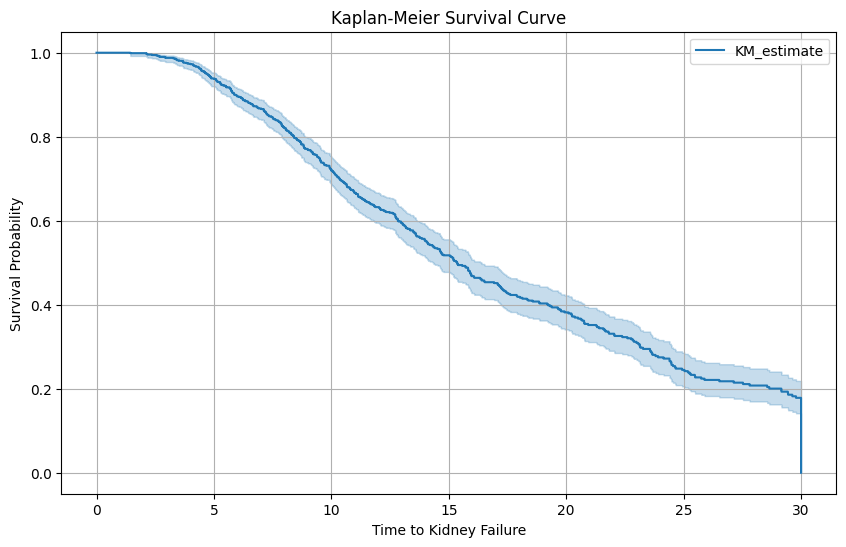

In [6]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Instantiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the data into the model
kmf.fit(df['time_to_failure'], event_observed=df['status'])

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time to Kidney Failure')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.savefig('1_min_KM.png')
plt.show()


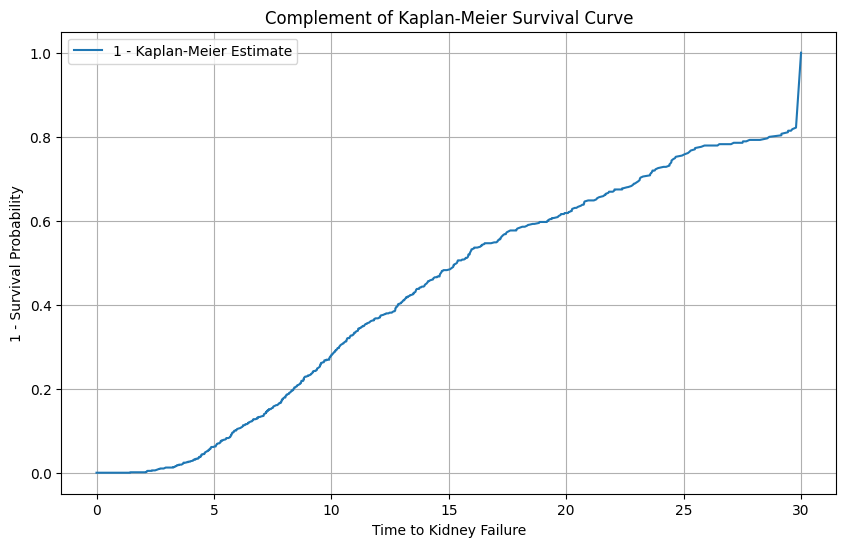

In [7]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Instantiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the data into the model
kmf.fit(df['time_to_failure'], event_observed=df['status'])

# Get the survival function
survival_function = kmf.survival_function_

# Compute 1 minus the survival function
complement_survival_function = 1 - survival_function

# Plot the complement of the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
plt.plot(complement_survival_function, label='1 - Kaplan-Meier Estimate')
plt.title('Complement of Kaplan-Meier Survival Curve')
plt.xlabel('Time to Kidney Failure')
plt.ylabel('1 - Survival Probability')
plt.legend()
plt.grid(True)
plt.savefig('1_min_KM.png')
plt.show()
